In [1]:
import numpy as np
import os, sys
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from PIL import Image

np.random.seed(68970) #for consistency

# Importing our data

The dataset comes split into two folders with one containing brain scans with tumors and another folder with those without. We need to go through each folder and read each image into lists. Since each brain scan has a different resolution, we need to resize the images as they come in to be a consistent size.

# Set the below macro to be the location of your dataset

In [2]:
DATA_FOLDER = 'brain_tumor_dataset'

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename),0)
        img = cv2.resize(img, (300,300), Image.ANTIALIAS)
        img = img / np.linalg.norm(img)
        if img is not None:
            images.append(img)
        
    return images


yes_images = load_images_from_folder(DATA_FOLDER+'/yes')
no_images = load_images_from_folder(DATA_FOLDER+'/no')

## The cell below is just to store data for later

In [4]:
#not used - was tryingt to use it for cross validation
num_yes = len(yes_images)
num_no = len(no_images)

X = no_images.copy()
for im in yes_images:
    X.append(im)
    
Y = [0] * num_no + [1] * num_yes


We split the data into yes and no lists to make labeling easier.

## Lets look at the data

There are 155 images with tumors and 98 images without tumors
The first image has (300, 300)


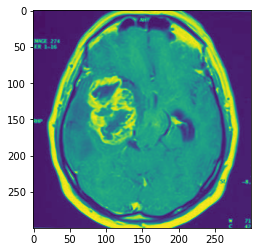

In [5]:
#Basic descriptors of dataset
plt.imshow(yes_images[0])
print("There are", len(yes_images), "images with tumors and", len(no_images), "images without tumors")
print("The first image has", np.shape(yes_images[0])) #image dimensions vary

# Formatting the data for KNN

KNN takes in one dimensional data as input, so we need to flatten each of the images.

In [6]:
yes_images = [im.flatten() for im in yes_images]
no_images = [im.flatten() for im in no_images]

#sanity checks
print(np.shape(yes_images))
print(np.shape(yes_images[1]))
print(yes_images[0])

(155, 90000)
(90000,)
[0.00030932 0.00038665 0.00048976 ... 0.00438204 0.0007733  0.0007733 ]


# Generating our test and train data
We will create a list containing (image, label) pairs, shuffle that list, and then distribute the first 70% of the shuffled list into the train set and the remaining 30% into a test set.

In [7]:
#Generate test and train set
yes_tuples = [(im, 1) for im in yes_images]
no_tuples = [(im,0) for im in no_images]
data_tuples = yes_tuples + no_tuples
np.random.shuffle(data_tuples) #mix up data_tuples

#Now data_tuples contains 253 brain scan and label pairs. Split into 70% train 30% test ~ 177 and 76
train_images, train_labels = zip(*data_tuples[:177])
test_images, test_labels = zip(*data_tuples[177:])

In [8]:
#Check that train and test have been appropriately split
print(len(train_images) + len(test_images))

253


# Generating our model

Using sklearn, we can easily generate a KNN model.

In [9]:
clf = KNeighborsClassifier(n_neighbors = 5, p = 2)
clf.fit(train_images, train_labels)
prediction_labels = clf.predict(test_images) #pregenerating test results to simplify below code. Will look at l8r.
print("Model Generation Complete")

Model Generation Complete


# Manual Checking

Let's pass the model a few images from the test set by hand to test the model's accuracy.

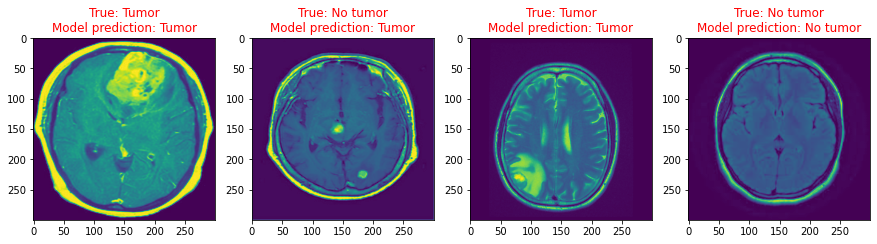

In [10]:
im1_pred_label = "Tumor" if prediction_labels[1] == 1 else "No tumor"
im1_corr_label = "Tumor" if test_labels[1] == 1 else "No tumor"

im2_pred_label = "Tumor" if prediction_labels[2] == 1 else "No tumor"
im2_corr_label = "Tumor" if test_labels[2] == 1 else "No tumor"

im3_pred_label = "Tumor" if prediction_labels[3] == 1 else "No tumor"
im3_corr_label = "Tumor" if test_labels[3] == 1 else "No tumor"

im4_pred_label = "Tumor" if prediction_labels[4] == 1 else "No tumor"
im4_corr_label = "Tumor" if test_labels[4] == 1 else "No tumor"

im1 = test_images[1].reshape(300,300)
im2 = test_images[2].reshape(300,300)
im3 = test_images[3].reshape(300,300)
im4 = test_images[4].reshape(300,300)


fig, ax = plt.subplots(1,4, figsize=(15,15))
ax[0].set_title("True: " + im1_corr_label + "\nModel prediction: " + im1_pred_label, color='red')
ax[0].imshow(im1)

ax[1].set_title("True: " + im2_corr_label + "\nModel prediction: " + im2_pred_label, color='red')
ax[1].imshow(im2)


ax[2].set_title("True: " + im3_corr_label + "\nModel prediction: " + im3_pred_label, color='red')
ax[2].imshow(im3)

ax[3].set_title("True: " + im4_corr_label + "\nModel prediction: " + im4_pred_label, color='red')
ax[3].imshow(im4)


# Interactive Model Testing

Each time you run the below cell, a random MRI image will be shown along with the model's guess as to whether there is a tumor present.

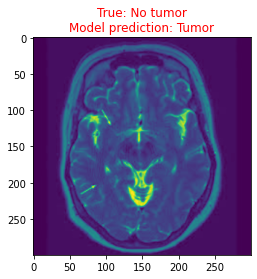

In [26]:
pred_range = len(prediction_labels)
random_idx = np.random.randint(0, pred_range-1)

im_pred_label = "Tumor" if prediction_labels[random_idx] == 1 else "No tumor"
im_corr_label = "Tumor" if test_labels[random_idx] == 1 else "No tumor"

im1 = test_images[random_idx].reshape(300,300)

plt.title("True: " + im_corr_label + "\nModel prediction: " + im_pred_label, color='red')
plt.imshow(im1)

# Now we will calculate an accuracy score for the KNN model generated using 5 neighbors and the l2 norm

In [12]:
print("SKLEARN ACCURACY: ", accuracy_score(test_labels, prediction_labels))

SKLEARN ACCURACY:  0.8026315789473685


# Now with cross validation

In [13]:
clf2 = KNeighborsClassifier(n_neighbors = 5, p = 2)
cross_validation_scores = cross_validate(clf2, X, Y)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_base.py", line 1131, in fit
    X, y = self._validate_data(X, y, accept_sparse="csr",
  File "/usr/local/lib/python3.8/dist-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py", line 795, in check_X_y
    X = check_array(X, accept_sparse=accept_sparse,
  File "/usr/local/lib/pyt